In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import uedge
from uedge import *
from uedge.hdf5 import *
import plotmesh as pm
from uetools import Case

UEDGE configuration file /home/kasaiyuki/.uetoolsrc read.


In [2]:
def setGrid(aeqdsk='aeqdsk', geqdsk='geqdsk', plot_true=True):

    print('setting grid using baseline_highR setGrid function')
    # Set the geometry
    bbb.mhdgeo = 1 # =1 use MHD equilibrium files
    com.geometry = 'dnbot'
    bbb.gengrid = 1
    com.isudsym = 1 # up-down symmetric

    geqdsk='MANTA_optimized__11122023'
    aeqdsk='aeqdsk'

    if aeqdsk:
        com.aeqdskfname = aeqdsk 
    if geqdsk:
        com.geqdskfname = geqdsk

    flx.xcutoff1 = 0.25 # set inner cutoff on the eqdsk data
    flx.ycutoff1 = 2.20 #1.50 #-2.3 #0.0 #1.50 # set lower cutoff on the eqdsk data
    flx.psi0min1 = 0.968 # normalized flux on core bndry
    flx.psi0min2 = 0.93 # normalized flux on pf bndry
    flx.psi0sep = 1.0001 # normalized flux at separatrix
    flx.psi0max = 1.078 # normalized flux on outer wall bndry
    flx.psi0max_inner = 1.078

    bbb.ngrid = 1 # number of mesh sequenc. (always set to 1)
    com.nxleg[0,0] = 16 # pol. mesh pts from inner plate to x-point
    com.nxcore[0,0] = 14 # pol. mesh pts from x-point to top on inside
    com.nxcore[0,1] = 10 # pol. mesh pts from top to x-point on outside
    com.nxleg[0,1] = 24 # pol. mesh pts from x-point to outer plate
    com.nysol[0] = 27 # rad. mesh pts in SOL
    com.nycore[0] = 17 # rad. mesh pts in core

    # com.nxxpt = 4
    # grd.nxmod = 1

    # Fix to avoid unnecessary interpolation
    bbb.isnintp = 1
    bbb.isgindx = 1

    #print(com.zshift)

    # Set correct strike points
    grd.isspnew = 1 # =1 for user-defined strike point
    grd.isztest = [2,2] # =0 for testing on rstrike only, =2 for testing on zstrike only and 2 elements for inner/outer strike points
    grd.zstrike[0] = 2.32#2.375#2.35#2.32 # inner R strike-point
    grd.zstrike[1] = 2.52#2.53#2.55#2.60#2.65 # outer Z strike-point

    # Set options for grid generator
    flx.alfcy = 2.1
    flx.alfcy_inner = 2.1
    grd.slpxt = 1.2
    grd.kxmesh = 1
    flx.altsearch = 0
    flx.istchkon = 1
    
    
    flx.flxrun() # required for next line
    # plt.plot(com.xcurve,com.ycurve,'.')
    # plt.show()
    grd.grdrun() # generate gridue file 

    com.nx=com.nxm
    com.ny=com.nym

    if plot_true:
        plt.plot(com.xcurve,com.ycurve,'.')
        plt.show()
        
        pm.plotmesh(iso=1)
    
    #non-orthog grid
    com.ismmon=3; grd.istream=0; grd.iplate=1; grd.nsmooth=5; grd.wtmesh1=0.75; grd.dmix0=1.0
    #plate_file = 'plate.ARC_NT_HV.py'
    #plate_file = 'plate.ARC_NT_HVslant.py'
    #plate_file = 'plate.ARC_NT_VslantVslant.py'
    plate_file = 'plate.ARC_NT_VsVs_shortleg.py'
    #plate_file = 'plate.ARC_NT_VslantV.py'
    exec(open(plate_file).read())

    flx.flxrun() # required for next line
    grd.grdrun() # generate gridue file 
    # bbb.gengrid = 0 # use existing gridue file

    com.nx=com.nxm
    com.ny=com.nym

    com.isnonog=1; bbb.methg=66
    if plot_true:
        pm.plotmesh(iso=1)


def setBoundaryConditions():
    global bbb

    # Boundary conditions
    bbb.isnicore[0] = 1	#=1 gives fixed uniform density ncore; =0 gives fixed particle flux
    bbb.ncore[0] = 1.5e20	#ion density on core if isnicore=1

    bbb.istewc = 2		#linear radial extrapolation condition for Te on outer wall
    bbb.istiwc = 2		#linear radial extrapolation condition for Ti outer wall
    bbb.isnwcono = 2		#linear radial extrapolation condition for ni on outer wall
    
    bbb.isnwconi = 1		##fixed ni=nwalli on PFR wall
    bbb.nwalli = 1e18
    bbb.istepfc = 1		#linear radial extrapolation condition for Te on PFR wall
    bbb.istipfc = 1		#linear radial extrapolation condition for Ti on PFR wall
	
    bbb.isupcore = 1		#=1 sets d(up)/dy=0

    bbb.iflcore = 1		#flag; =0, fixed Te,i; =1, fixed ion,elec core power
    bbb.pcoree = 6.5e6		#core elec power if iflcore=1
    bbb.pcorei = 6.5e6		#core ion power if iflcore=1

    bbb.recycp[0] = 1.0	#hydrogen recycling coeff at plates
    bbb.recycw[0] = 1.0	#hydrogen recycling coeff at wall boundaries
    
    bbb.bcee = 4.0		#target plate electron sheath coefficient
    bbb.bcei = 2.5		#target plate ion sheath coefficient

    bbb.istgwc = 0
    bbb.istgpfc = 0


def setSolver(experimental=False):
    global bbb
    # Solver package
    bbb.svrpkg = 'nksol'	#Newton solver using Krylov method
    bbb.premeth = 'ilut'	#Solution method for precond Jac'n matrix
    bbb.mfnksol = -3		# =3 for restricted increase in fnrm
    bbb.lfililut = 200
    bbb.lenplufac = 300	
    bbb.lenpfac = 200
    bbb.rlx = 0.1
    #del = 1.e-7
    bbb.epscon1 = 3e-3		#linear solver convergence
    bbb.n0g[0] = 1e18

    # Finite-difference algorithms (upwind, central diff, etc.)
    bbb.methn = 33 # ion continuity eqn
    bbb.methu = 33 # ion parallel momentum eqn
    bbb.methe = 33 # electron energy eqn
    bbb.methi = 33 # ion energy eqn
    bbb.methg = 66 # neutral gas continuity eqn


def setPhysics(impFrac=0.0):
    global bbb, com, aph

    # Ion Mass
    bbb.minu[0:2]=2.5		#D-T plasma

    # Flux limits
    bbb.isflxlde = 1
    bbb.isflxldi = 2
    bbb.flalfe = 10		#electron parallel thermal conduct. coeff
    bbb.flalfi = 10		#ion parallel thermal conduct. coeff
    bbb.flalfv = 0.5		#ion parallel viscosity coeff
    bbb.flgamv = 1.
    bbb.flalfgx = 1.		#neut. gas in poloidal direction
    bbb.flalfgy = 1.		#neut. gas in radial direction
    bbb.flalftgx = 1.		#neut power in poloidal direction
    bbb.flalftgy = 1.		#neut power in radial direction
    bbb.lgmax = 0.05		#max scale for gas particle diffusion
    bbb.lgtmax = 0.05		#max scale for gas thermal diffusion


    # Atomic Physics
    com.istabon = 10		#Stotler tables
    bbb.isrecmon = 1		#=1 for recombination
    aph.aphdir='aph/'

    ### source number 1:
    bbb.jxsoro[0] = 1		# this wall source starts in mesh region 1
    bbb.jxsori[0] = 1		# this pf source starts in mesh region 1
    bbb.matwso[0] = 1.
    bbb.matwsi[0] = 1.
    bbb.wgaso[0] = 1e3
    bbb.wgasi[0] = 1e3
    

    # Neutrals
    bbb.ineudif=2		
    bbb.cngfx=0.		#only effective when ineudif=1
    bbb.cngfy=0.		#only effective when ineudif=1
    bbb.cngflox=0.	#default#flux from convection
    bbb.cngfloy=0.	#default#flux from convection
    bbb.ngbackg=1e10

    # Inertial neutrals
    com.nhsp=2
    bbb.ziin[1]=0.
    bbb.isngon[0]=0
    bbb.isupgon[0]=1
    bbb.cngmom=0
    bbb.cmwall=0
    bbb.cngtgx=0
    bbb.cngtgy=0
    bbb.cfbgt=0
    bbb.kxn=0
    bbb.kyn=0
    bbb.recycm = -0.95	#latest recommmendation

    bbb.allocate()
    bbb.nphygeo()

    # Impurities
    if (impFrac>1e-8):
        bbb.isimpon = 2
        bbb.afracs = impFrac
        bbb.allocate()
    else:
        bbb.isimpon = 0


    bbb.kxe=1.0 #-parallel conduction factor                                                    
    bbb.islnlamcon=1 	#-Coulomb log                                                              
    bbb.lnlam=12
    bbb.isplflxlv=1 #=0, flalfv not active at ix=0 & nx;=1 active all ix                         
    bbb.isplflxlgx=1
    bbb.isplflxlgxy=1
    bbb.isplflxlvgx=1
    bbb.isplflxlvgxy=1
    bbb.iswflxlvgy=1
    bbb.isplflxltgx=1
    bbb.isplflxltgxy=1
    bbb.iswflxltgy=1 #-the main one, the only one that really matters                            
    bbb.isplflxl=1   # =0, flalfe,i not active at ix=0 & nx;=1 active all ix                     
    bbb.iswflxlvgy=1 # integer /1/ #=0, flalfvgy not active at iy=0 & ny;=1 active all iy        
    bbb.cngflox=1    # real /ngspmx*1./ #fac for x-flux from convection in ng-eqn.               
    bbb.isupwi=1     # integer /nispmx*1/ #=2 sets dup/dy=0 on inner wall                        
    bbb.isupwo=1     # integer /nispmx*1/ #=2 sets dup/dy=0 on outer wall
    
    
    #Divertor pumping
    bbb.nwsor = 2	#Add +1 new wall source
    
    bbb.issorlb[1]=0	#Set xgasi as distance from outer target
    bbb.xgasi[1]=0.1	#Set source location on ny=0 boundary (PFR)
    bbb.wgasi[1]=0.2	#Set width of source(/sink) region
    
    bbb.albdsi[1]=1.0 #0.9997 #1.0 #0.999 #Set neutral albedo for PFR source
    bbb.igasi[1]=-820
    
  


def setDChi(DOutFactor=1, DInFactor=1, chiInb=0.1, convec=False):
    """
    Arguments
        chiInb: constant chi on inboard side, increasing it decreases P_inner_xpt
        convec: set radial v_conv on outboard side
    """
    # Transport coefficients (m**2/s) 
    bbb.travis[0] = 1.0 # eta_a for radial ion momentum diffusion
    bbb.difutm = 0.50 # toroidal diffusivity for potential
    bbb.difni[0] = 0#0.025		#D for radial hydrogen diffusion
    bbb.kye = 0.#0.0075		#chi_e for radial elec energy diffusion
    bbb.kyi = 0.#0.0075		#chi_i for radial ion energy diffusion
    bbb.isbohmcalc = 0
    bbb.facbee = 1.0 # factor for Bohm Te diffusion coeff
    bbb.facbei = 1.0 # factor for Bohm Ti diffusion coeff
    bbb.facbni = 1.0 # factor for Bohm ni diffusion coeff
    bbb.nphygeo() # calculate radial coords of grid centers, yyc
    
    xoutboard = slice(bbb.ixmp, com.ixpt2[0]+1)
    xinboard = slice(0, bbb.ixmp)
    xoleg = slice(com.ixpt2[0]+1, com.nx+2)
    xileg = slice(0, com.ixpt1[0]+1)
    ycore = slice(0, com.iysptrx+2)
    ysol = slice(com.iysptrx, com.ny+2)

    # Profile of D on outboard side
#    DOut = 0.08*exp(com.yyc/2e-1)
#    DOut[0:com.iysptrx+1] = 0.08

    DOut = 0.026
    DInb = 0.026
    Dpfr = 0.10

    # Set D
    bbb.dif_use[xoutboard,:,0] = bbb.dif_use[xoleg,:,0] = DOut #DOut*DOutFactor 
    bbb.dif_use[xinboard,:,0]  = bbb.dif_use[xileg,:,0] = DInb #0.1*DInFactor 

    # set larger D in PFR
    bbb.dif_use[xoleg,ycore,0] = bbb.dif_use[xileg,ycore,0] = Dpfr
    

    # Profile of chi on outboard side
    #chimax = 0.1
    #reldepth = 0.12 # deepest point in well is chimax*(1-reldepth)

    #chiOut = chimax*((0.*com.yyc+1.) - reldepth*exp(-(com.yyc/1e-3)**2))

    chiOut = 0.015
    chiInb = 0.004 #0.0008
    chiInbpfr = 0.004 #0.003
    # Set chi
    bbb.kye_use[xoutboard,:] = bbb.kyi_use[xoutboard,:] = chiOut
    bbb.kye_use[xinboard,:]  = bbb.kyi_use[xinboard,:]  = chiInb 
    bbb.kye_use[xoleg,:]     = bbb.kyi_use[xoleg,:]     = chiOut
    bbb.kye_use[xileg,:]     = bbb.kyi_use[xileg,:]     = chiInb
   
    # also set larger chi in PFR (on inboard side)
    bbb.kye_use[xileg,ycore] = bbb.kyi_use[xileg,ycore] = chiInbpfr
 
    #if convec:
        #-set radial velocity in outermost radial layer
        #bbb.dif_use[: ,com.ny-1:com.ny+2, 0]=0.0
        #bbb.vy_use[:, com.ny-1:com.ny+2, 0]=1e2
        
        #-set radial velocity on PF boundary, inner leg
        #bbb.dif_use[0:com.ixpt1[0]+1, 0:3, 0]=0.0
        #bbb.vy_use[0:com.ixpt1[0]+1, 0:3, 0]=-1e2
        #
        #-set radial velocity on PF boundary, outer leg
        #bbb.dif_use[com.ixpt2[0]+1:com.nx+2, 0:3, 0]=0.0
        #bbb.vy_use[com.ixpt2[0]+1:com.nx+2, 0:3, 0]=-1e2 
        
    
def setup(impFrac=0.0, experimental=False, convec=False, plot_true=True):
    setGrid(plot_true=plot_true)
    setBoundaryConditions()
    setSolver(experimental=experimental)
    setPhysics(impFrac=impFrac)
    setDChi(convec=convec)
                   
       
    
    
def restore(name='uerun'):
    global bbb
    h5file = name + '.h5'
    if os.path.isfile(h5file):
        bbb.label[0] = name 
        bbb.restart = 1
        hdf5_restore(name + '.h5')
        bbb.dtreal = 1e-2
        bbb.exmain() 
    else:
        raise OSError(2, 'No such file', h5file)          
    


In [4]:
#Running UEdge 
setup(impFrac=3e-3, experimental=False,convec=False, plot_true=False)

restore('base_ITback_chi15e2_4e3pfr_D26_P26_imp3e3')

setting grid using baseline_highR setGrid function
 
***  alfcy_inner is set to alfcy_outer  ***
 
 
     alfcy_inner =   2.100000E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:    FREEGS 11/12/2023                                         

4.5
 
***  alfcy_inner is set to alfcy_outer  ***
 
 
     alfcy_inner =   2.100000E+00
 ***** Grid generation has been completed
 
***  alfcy_inner is set to alfcy_outer  ***
 
 
 Wrote file "gridue" with runid:    FREEGS 11/12/2023                                         

     alfcy_inner =   2.100000E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:    FREEGS 11/12/2023                                         

 
***  alfcy_inner is set to alfcy_outer  ***
 
 
     alfcy_inner =   2.100000E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:    FREEGS 11/12/2023                                         


Reading uedge.hdf5-style save-file 'base_ITback_chi15e2_

1.2.2rc2


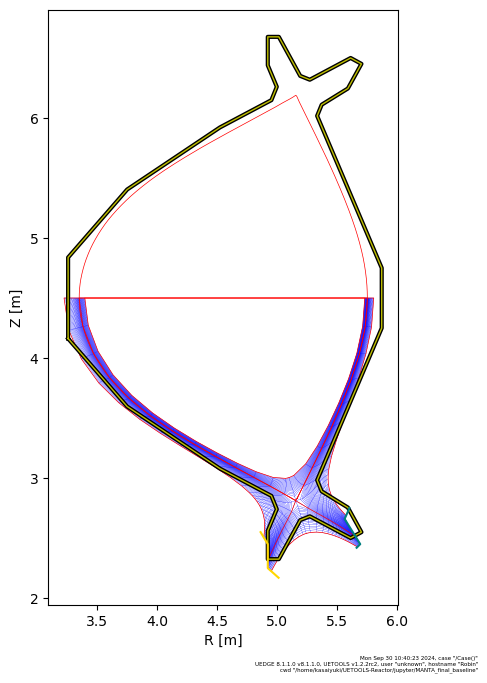

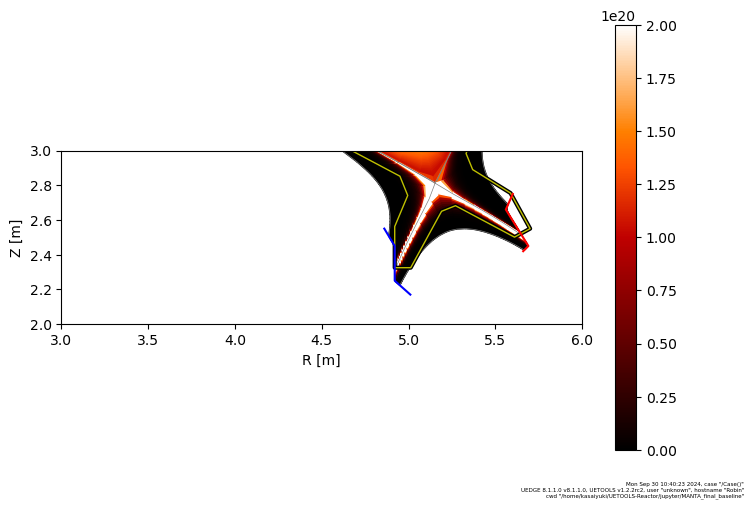

In [5]:
# UETOOLS Start
import uetools
print(uetools.__version__)
c = uetools.Case()
#c.plot.ne2d()
#bbb.exmain()
c.plot.grid(linewidth=0.1, #grid plot
       vessel=True, 
       plates=True, 
       platecolor=['gold','teal'], 
       lcfs=True, 
       lcfscolor='r', 
       linecolor='b'
      );

c.plot.mesh( #electron density
    c.get('ne'), 
    xlim=(3, 6), 
    ylim=(2,3), 
    figsize=(7,5), 
    zrange=(0,2e20), 
    cmap='gist_heat'
);